In [6]:
# open indiawater.geojson 
filename = 'indiawater.geojson'

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

file = gpd.read_file(filename)

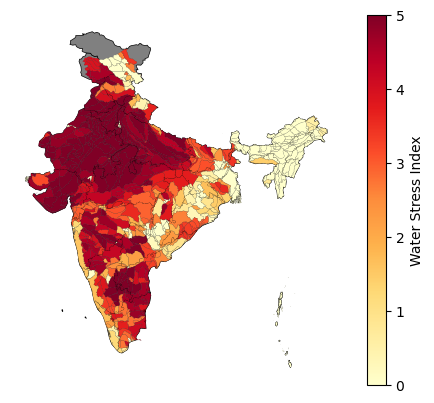

In [15]:
# plot the polygons with the colors of water data from indiawater.geoson
# shape determined by 'geometry'
# color determined by 'bws_raw'
fp = 'india-polygon.shp'
States = gpd.GeoDataFrame.from_file(fp)
ax = States.plot(edgecolor='k', color='gray', linewidth=0.5)
ax2 = file.plot(column='bws_score', cmap='YlOrRd', edgecolor='k', lw=0.05, legend=True,
          legend_kwds={'label': "Water Stress Index"}, ax=ax)
ax.set_axis_off()
plt.savefig('./Feature_plots/WRI_water_stress.png')


In [3]:
from shapely.geometry import Point
# write a function given a coordinate, return the water stress score

def water_stress_score(lat, lon):
    # find the polygon that contains the point
    for i in range(len(file)):
        if file.geometry[i].contains(Point(lon, lat)):
            return file.bws_score[i]
    return None

In [4]:
power_plants = pd.read_csv('GEM_original_data/India_coal_power_plants.csv')

# add a new column to the power_plants dataframe called 'bws_score'
power_plants['bws_score'] = power_plants.apply(lambda row: water_stress_score(row['Latitude'], row['Longitude']), axis=1)

In [5]:
import numpy as np
coal_price = pd.read_csv('State_wise_coal_price.csv')

# coal_price: columns State, INR/Mcal
# power_plants: column Subnational unit (province, state)

# rename Punjab state to Punjab in power_plants
power_plants['Subnational unit (province, state)'] = power_plants['Subnational unit (province, state)'].replace('Punjab State', 'Punjab')

# drop Puducherry from power_plants
power_plants = power_plants[power_plants['Subnational unit (province, state)'] != 'Puducherry']

# add a new column to the power_plants dataframe called 'coal_price'
def get_coal_price(row):
    res = coal_price[coal_price['State'] == row['Subnational unit (province, state)']]['INR/Mcal']
    if res is not None and len(res) > 0:
        # format res.values[0] as 2 decimal places
        return round(res.values[0], 2)
    return np.nan
power_plants['coal_price'] = power_plants.apply(get_coal_price, axis=1)

In [6]:
# export the power_plants dataframe to a csv file
power_plants.to_csv('gem_with_ws_price.csv', index=False)

In [7]:
def add_features(filename):
    critical_csv = pd.read_csv('CEEW_original_data' + '/' + filename + '.csv')
    # need to add coal price and water stress

    water_stress_state = pd.read_csv('state_water_stress.csv')
    water_stress_state = water_stress_state.set_index(water_stress_state.iloc[:, 0])
    critical_csv['bws_score'] = critical_csv.apply(lambda row: water_stress_state.loc[row['State']]['bws'], axis=1)

    def get_coal_price(row):
        res = coal_price[coal_price['State'] == row['State']]['INR/Mcal']
        if res is not None and len(res) > 0:
            # format res.values[0] as 2 decimal places
            return round(res.values[0], 2)
        return np.nan

    critical_csv['coal_price'] = critical_csv.apply(get_coal_price, axis=1)

    critical_csv.to_csv(f'CEEW_{filename}_with_ws_price.csv', index=False)

In [8]:
add_features('subcritical') # created from CEEW
add_features('supercritical')